In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from ast import literal_eval
from skimpy import skim

In [2]:
cpcb_data_raw = pd.read_csv("../data/processed/cpcb_aqi_data.csv", parse_dates=["date"])
delhi_climate_data_raw = pd.read_csv("../data/processed/delhi_nasa_power_climate_data.csv", index_col=0, parse_dates=["date"], na_values=-999)

In [3]:
cpcb_data_raw.head()

,City,Air Quality,Index Value,Prominent Pollutant,Based on Number of Monitoring Stations,date
0,Agartala,Moderate,180,['PM2.5'],1,2022-02-26
1,Agra,Satisfactory,89,['PM10'],5,2022-02-26
2,Ahmedabad,Poor,235,['PM2.5'],9,2022-02-26
3,Aizawl,Good,15,['CO'],1,2022-02-26
4,Ajmer,Moderate,122,['PM10'],1,2022-02-26


In [5]:
delhi_climate_data_raw.head()

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,ALLSKY_SFC_LW_DWN,PS,WS10M,...,CDD0,CDD10,CDD18_3,HDD0,HDD10,HDD18_3,QV2M,RH2M,PRECTOTCORR,date
20200101,-18.68,-17.45,-18.06,-13.35,1.78,-17.76,-19.53,197.63,99.27,6.59,...,0.0,0.0,0.0,18.62,28.62,36.94,0.85,100.00,0.28,2020-01-01
20200102,-18.12,-17.09,-17.60,-12.67,1.38,-17.48,-18.86,189.40,99.01,6.70,...,0.0,0.0,0.0,18.19,28.19,36.50,0.92,100.00,0.49,2020-01-02
20200103,-14.80,-14.87,-14.83,-10.88,4.94,-12.84,-17.77,210.04,98.12,9.24,...,0.0,0.0,0.0,15.31,25.31,33.62,1.10,99.56,0.66,2020-01-03
20200104,-13.14,-14.27,-13.70,-10.58,2.94,-11.56,-14.50,229.05,98.14,10.20,...,0.0,0.0,0.0,13.06,23.06,31.31,1.16,94.31,0.75,2020-01-04
20200105,-13.33,-14.39,-13.86,-10.92,2.71,-11.55,-14.26,219.48,99.45,10.28,...,0.0,0.0,0.0,12.88,22.88,31.19,1.16,94.88,0.34,2020-01-05



---

## **Data Cleanup**

### **Using MultiLabelBinarizer for One-Hot Encoding Prominent Pollutant**
The MultiLabelBinarizer from sklearn.preprocessing is a simple and effective way to convert multi-label data into a one-hot encoded format.


#### **Before Cleanup**
The original data looks like this:

| Prominent Pollutant   |
|:----------------------|
| ['PM10', 'PM2.5']     |
| ['PM2.5']             |
| ['PM2.5']             |


#### **After Cleanup**
After applying MultiLabelBinarizer, the data is transformed into a one-hot encoded format:


|   CO |   NH3 |   NO2 |   O3 |   PM10 |   PM2.5 |   SO2 |
|-----:|------:|------:|-----:|-------:|--------:|------:|
|    0 |     0 |     0 |    0 |      1 |       1 |     0 |
|    0 |     0 |     0 |    0 |      0 |       1 |     0 |
|    0 |     0 |     0 |    0 |      0 |       1 |     0 |
|    1 |     0 |     0 |    0 |      1 |       0 |     0 |
|    0 |     0 |     0 |    0 |      1 |       1 |     0 |

In [6]:
mlb = MultiLabelBinarizer()
mlb.fit(cpcb_data_raw["Prominent Pollutant"].apply(lambda x: literal_eval(x)))
prominent_pollutant_ohe_data = mlb.transform(cpcb_data_raw["Prominent Pollutant"].apply(lambda x: literal_eval(x)))
prominent_pollutant_ohe_df = pd.DataFrame(data=prominent_pollutant_ohe_data, columns=mlb.classes_, index=cpcb_data_raw.index)
prominent_pollutant_ohe_df.head()

,CO,NH3,NO2,O3,PM10,PM2.5,SO2
0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0


In [13]:
# Dropping unused columns and adding one hot encoding
# Cleaning up spaces from column names
raw_col_names = cpcb_data_raw.columns

columns_to_drop = ['Air_Quality', 'Based_on_Number_of_Monitoring_Stations', 'Prominent_Pollutant']
cpcb_df = (cpcb_data_raw.merge(prominent_pollutant_ohe_df, how="inner", left_index=True, right_index=True)
           .rename(columns={col: col.replace(" ", "_") for col in raw_col_names})
           .drop(columns_to_drop, axis=1)
)

In [14]:
cpcb_df

,City,Index_Value,date,CO,NH3,NO2,O3,PM10,PM2.5,SO2
0,Agartala,180,2022-02-26,0,0,0,0,0,1,0
1,Agra,89,2022-02-26,0,0,0,0,1,0,0
2,Ahmedabad,235,2022-02-26,0,0,0,0,0,1,0
3,Aizawl,15,2022-02-26,1,0,0,0,0,0,0
4,Ajmer,122,2022-02-26,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
302426,Vatva,166,2020-02-24,0,0,0,0,0,1,0
302427,Vijayapura,67,2020-02-24,0,0,0,0,0,1,0
302428,Visakhapatnam,137,2020-02-24,0,0,0,0,1,0,0
302429,Yadgir,65,2020-02-24,0,0,0,1,0,0,0


In [15]:
skim(cpcb_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 302431 │ │ int64       │ 8     │                                                          │
│ │ Number of columns │ 10     │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA   ┃ NA %   ┃ mean         ┃ sd         ┃ p0  ┃ p25   ┃ p50   ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ Index_Value     │    0 │      0 │        113.9 │      77.17 │   3 │    58 │    91 │  147 │   500 │  ▇▆▂▁   │  │
│ │ CO              │    0 │      0 │      0.08903 │     0.2848 │   0 │     0 │     0 │    0 │     1 │ ▇    ▁  │  │
│ │ NH3             │    0 │      0 │    0.0003571 │    0.01889 │   0 │     0 │     0 │    0 │     1 │    ▇    │  │
│ │ NO2             │    0 │      0 │      0.02583 │     0.1586 │   0 │     0 │     0 │    0 │     1 │    ▇    │  │
│ │ O3              │    0 │      0 │       0.1102 │     0.3132 │   0 │     0 │     0 │    0 │     1 │ ▇    ▁  │  │
│ │ PM10            │    0 │      0 │       0.5515 │     0.4973 │   0 │     0 │     1 │    1 │     1 │ ▇    ▇  │  │
│ │ PM2.5           │    0 │      0 │       0.3427 │     0.4746 │   0 │     0 │     0 │    1 │     1 │ ▇    ▅  │  │
│ │ SO2             │    0 │      0 │      0.02064 │     0.1422 │   0 │     0 │     0 │    0 │     1 │    ▇    │  │
│ └─────────────────┴──────┴────────┴──────────────┴────────────┴─────┴───────┴───────┴──────┴───────┴─────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ date                   │      0 │         0 │     2020-01-01      │     2024-11-30      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ City                      │       0 │          0 │                            1 │                   312225 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── 

### Impuating missing values for the climate data using SimpleImputer

In [28]:
skim(delhi_climate_data_raw)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1797   │ │ float64     │ 37    │                                                          │
│ │ Number of columns │ 38     │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name          ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0     ┃ p25    ┃ p50    ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ T2M                  │   3 │  0.17 │  -2.738 │   7.033 │ -28.53 │  -5.49 │ -0.845 │  2.17 │   9.4 │  ▁▂▃▇▃ │  │
│ │ T2MDEW               │   3 │  0.17 │  -4.154 │   6.995 │ -28.26 │ -7.992 │  -2.75 │  0.98 │  8.68 │  ▁▂▅▇▃ │  │
│ │ T2MWET               │   3 │  0.17 │  -3.446 │   6.992 │ -28.39 │ -6.627 │  -1.81 │  1.65 │  9.02 │  ▁▂▃▇▃ │  │
│ │ TS                   │   3 │  0.17 │  -1.554 │   6.434 │ -26.49 │   -3.1 │  -0.11 │  2.69 │   8.5 │  ▁▁▂▇▅ │  │
│ │ T2M_RANGE            │   3 │  0.17 │    2.36 │   2.369 │   0.12 │   0.93 │   1.55 │  2.83 │ 18.13 │   ▇▂   │  │
│ │ T2M_MAX              │   3 │  0.17 │  -1.555 │   6.418 │    -25 │ -3.763 │  -0.05 │ 2.868 │  9.91 │  ▁▁▃▇▂ │  │
│ │ T2M_MIN              │   3 │  0.17 │  -3.915 │   7.621 │ -31.28 │ -7.515 │ -1.715 │ 1.588 │  9.19 │  ▁▂▃▇▃ │  │
│ │ ALLSKY_SFC_LW_DWN    │   0 │     0 │     271 │    40.3 │  153.9 │  245.5 │  275.9 │ 301.9 │   358 │ ▁▃▅▇▇▂ │  │
│ │ PS                   │   3 │  0.17 │   100.8 │   1.223 │  95.85 │  100.1 │    101 │ 101.7 │ 103.9 │  ▁▃▇▇▁ │  │
│ │ WS10M                │   3 │  0.17 │   7.078 │   2.978 │   1.02 │   4.89 │    6.8 │  8.96 │ 17.11 │ ▃▇▇▅▁  │  │
│ │ WS10M_MAX            │   3 │  0.17 │   9.186 │   3.367 │   1.62 │  6.723 │  8.805 │ 11.54 │ 23.73 │  ▃▇▇▃  │  │
│ │ WS10M_MIN            │   3 │  0.17 │   4.851 │   2.969 │   0.06 │   2.51 │   4.52 │ 6.728 │ 16.13 │ ▇▇▆▂▁  │  │
│ │ WS10M_RANGE          │   3 │  0.17 │   4.335 │   2.651 │   0.32 │   2.41 │   3.74 │  5.54 │ 19.92 │  ▇▆▂▁  │  │
│ │ WS50M                │   3 │  0.17 │   8.299 │   3.386 │   1.15 │   5.76 │   8.06 │ 10.54 │ 19.61 │ ▃▇▇▅▁  │  │
│ │ WD10M                │   3 │  0.17 │   164.7 │   91.26 │   2.31 │  85.44 │  160.2 │ 238.5 │ 354.6 │ ▆▇▇▇▆▃ │  │
│ │ WS50M_MAX            │   3 │  0.17 │   10.69 │   3.818 │   1.85 │  7.933 │  10.45 │ 13.34 │ 27.67 │  ▂▇▇▃  │  │
│ │ WS50M_MIN            │   3 │  0.17 │   5.771 │    3.44 │   0.05 │  3.022 │  5.465 │ 8.045 │ 18.46 │ ▇▇▇▃▁  │  │
│ │ WS50M_RANGE          │   3 │  0.17 │   4.919 │   3.049 │   0.33 │    2.7 │  4.215 │ 6.338 │ 22.67 │  ▇▆▂▁  │  │
│ │ WD50M                │   3 │  0.17 │   164.7 │   91.18 │   2.44 │  85.95 │  160.1 │ 237.6 │ 354.6 │ ▆▇▇▇▆▃ │  │
│ │ ALLSKY_SFC_SW_DNI    │ 153 │  8.51 │   7.776 │   10.85 │      0 │      0 │   4.33 │ 10.04 │ 65.15 │  ▇▁▁   │  │
│ │ ALLSKY_SFC_SW_DIFF   │ 153 │  8.51 │    4.19 │   4.624 │      0 │      0 │   2.19 │  8.28 │ 17.13 │ ▇▂▂▂▁  │  │
│ │ TOA_SW_DWN           │   9 │   0.5 │   16.01 │   16.62 │      0 │      0 │  9.605 │ 32.72 │ 44.24 │ ▇▂▁▁▁▃ │  │
│ │ ALLSKY_SRF_ALB       │ 644 │ 35.84 │  0.2426 │  0.22

In [35]:
# Using SimpleImputer to impute mean for missing values
climate_continous_cols = delhi_climate_data_raw.columns.drop('date')
imputer = SimpleImputer()
climate_imputed_data = imputer.fit_transform(delhi_climate_data_raw[climate_continous_cols])
delhi_climate_data_df = pd.DataFrame(data=climate_imputed_data, index=delhi_climate_data_raw.index, columns=imputer.feature_names_in_)
delhi_climate_data_df['date'] = delhi_climate_data_raw['date']

In [36]:
skim(delhi_climate_data_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1797   │ │ float64     │ 37    │                                                          │
│ │ Number of columns │ 38     │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name          ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0     ┃ p25   ┃ p50    ┃ p75    ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ T2M                  │   0 │     0 │  -2.738 │   7.027 │ -28.53 │ -5.49 │  -0.85 │   2.17 │   9.4 │  ▁▂▃▇▃ │  │
│ │ T2MDEW               │   0 │     0 │  -4.154 │   6.989 │ -28.26 │ -7.97 │  -2.77 │   0.98 │  8.68 │  ▁▂▅▇▃ │  │
│ │ T2MWET               │   0 │     0 │  -3.446 │   6.986 │ -28.39 │ -6.62 │  -1.81 │   1.65 │  9.02 │  ▁▂▃▇▃ │  │
│ │ TS                   │   0 │     0 │  -1.554 │   6.429 │ -26.49 │  -3.1 │  -0.11 │   2.69 │   8.5 │  ▁▁▂▇▅ │  │
│ │ T2M_RANGE            │   0 │     0 │    2.36 │   2.367 │   0.12 │  0.93 │   1.55 │   2.83 │ 18.13 │   ▇▂   │  │
│ │ T2M_MAX              │   0 │     0 │  -1.555 │   6.412 │    -25 │ -3.74 │  -0.08 │   2.86 │  9.91 │  ▁▁▃▇▂ │  │
│ │ T2M_MIN              │   0 │     0 │  -3.915 │   7.614 │ -31.28 │  -7.5 │  -1.73 │   1.58 │  9.19 │  ▁▂▃▇▃ │  │
│ │ ALLSKY_SFC_LW_DWN    │   0 │     0 │     271 │    40.3 │  153.9 │ 245.5 │  275.9 │  301.9 │   358 │ ▁▃▅▇▇▂ │  │
│ │ PS                   │   0 │     0 │   100.8 │   1.222 │  95.85 │ 100.1 │    101 │  101.7 │ 103.9 │  ▁▃▇▇▁ │  │
│ │ WS10M                │   0 │     0 │   7.078 │   2.975 │   1.02 │  4.89 │    6.8 │   8.96 │ 17.11 │ ▃▇▇▅▁  │  │
│ │ WS10M_MAX            │   0 │     0 │   9.186 │   3.365 │   1.62 │  6.73 │   8.81 │  11.54 │ 23.73 │  ▃▇▇▃  │  │
│ │ WS10M_MIN            │   0 │     0 │   4.851 │   2.966 │   0.06 │  2.51 │   4.52 │   6.72 │ 16.13 │ ▇▇▆▂▁  │  │
│ │ WS10M_RANGE          │   0 │     0 │   4.335 │   2.649 │   0.32 │  2.41 │   3.74 │   5.54 │ 19.92 │  ▇▆▂▁  │  │
│ │ WS50M                │   0 │     0 │   8.299 │   3.383 │   1.15 │  5.76 │   8.07 │  10.54 │ 19.61 │ ▃▇▇▅▁  │  │
│ │ WD10M                │   0 │     0 │   164.7 │   91.19 │   2.31 │ 85.62 │  160.3 │  238.4 │ 354.6 │ ▆▇▇▇▆▃ │  │
│ │ WS50M_MAX            │   0 │     0 │   10.69 │   3.814 │   1.85 │  7.94 │  10.45 │  13.33 │ 27.67 │  ▂▇▇▃  │  │
│ │ WS50M_MIN            │   0 │     0 │   5.771 │   3.437 │   0.05 │  3.03 │   5.48 │   8.03 │ 18.46 │ ▇▇▇▃▁  │  │
│ │ WS50M_RANGE          │   0 │     0 │   4.919 │   3.046 │   0.33 │   2.7 │   4.23 │   6.33 │ 22.67 │  ▇▆▂▁  │  │
│ │ WD50M                │   0 │     0 │   164.7 │    91.1 │   2.44 │    86 │  160.2 │  237.4 │ 354.6 │ ▆▇▇▇▆▃ │  │
│ │ ALLSKY_SFC_SW_DNI    │   0 │     0 │   7.776 │   10.38 │      0 │     0 │   5.22 │   9.16 │ 65.15 │  ▇▁▁   │  │
│ │ ALLSKY_SFC_SW_DIFF   │   0 │     0 │    4.19 │   4.423 │      0 │     0 │   3.01 │   7.72 │ 17.13 │ ▇▃▂▂▁  │  │
│ │ TOA_SW_DWN           │   0 │     0 │   16.01 │   16.58 │      0 │     0 │   9.82 │   32.6 │ 44.24 │ ▇▂▁▁▁▃ │  │
│ │ ALLSKY_SRF_ALB       │   0 │     0 │  0.2426 │  0.18

---

## EDA

In [38]:
merged_cpcb_climate_df = cpcb_df.merge(delhi_climate_data_df, how="left", left_on="date", right_on="date")

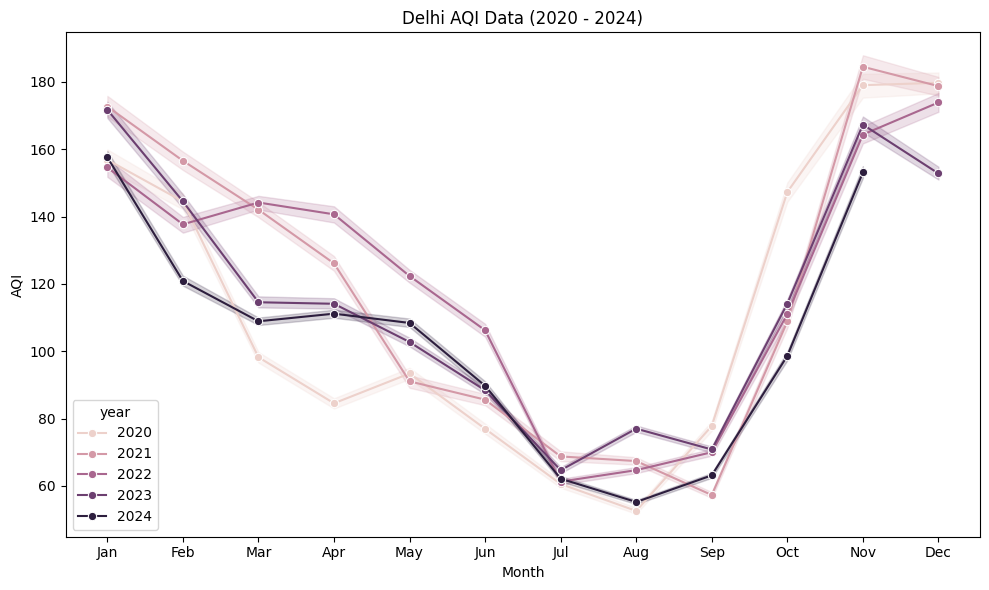

In [33]:
merged_cpcb_climate_df['year'] = merged_cpcb_climate_df['date'].dt.year
merged_cpcb_climate_df['month'] = merged_cpcb_climate_df['date'].dt.month

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='Index_Value', hue='year', data=merged_cpcb_climate_df, marker='o')

plt.title('Delhi AQI Data (2020 - 2024)')
plt.xlabel('Month')
plt.ylabel('AQI')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()